In [ ]:
##################################################################################
## Script for extracting sequential patterns
## from data associated to trajectories of
## locations (visits) in Lille city, France
##################################################################################
## This program is free software: you can redistribute it and/or modify
## it under the terms of the GNU General Public License as published by
## the Free Software Foundation, either version 3 of the License, or
## (at your option) any later version.
## This program is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
## GNU General Public License for more details.
## You should have received a copy of the GNU General Public License
## along with this program.  If not, see <https://www.gnu.org/licenses/>.
##################################################################################
## Author: Hugo Alatrista-Salas
## Copyright: Copyright 2023, Data Turism & MEL Project (Research center ESILV)
## Credits: [Hugo Alatrista-Salas]
## License: GPL
## Version: 1.0.1
## Mmaintainer: [Hugo Alatrista-Salas]
## Email: hugo.alatrista_salas@devinci.fr
## Status: Proof of concept
##################################################################################

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Basic Librariess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import log
from pylab import *

# Other libraries
import warnings
warnings.filterwarnings('ignore')

# Libraries for buiding graphs (igraph is quickly than networkx)
import igraph as ig
from igraph import *

# OSM library and Folium
import osmnx as ox
import folium
from folium.plugins import FloatImage # Lib to add a legend to a figure

# Libraries for recovering CSV files
import csv

# To show complete matrices
np.set_printoptions(threshold=np.inf)

In [3]:
## Function to build a grap with the Lille Commune using a bounding box
## input: a string (walk, all, car, bike)
## output: a graph

def building_OSM_lille(type):
    type_t_walk = type 
    north, south, east, west = 50.85, 50.52, 3.27, 2.88 # Coordinates that envelope Lille (aprox)
    graph_Lille = ox.graph_from_bbox(
        north, 
        south, 
        east, 
        west, 
        network_type = type_t_walk)
    return graph_Lille

In [4]:
## Calculating the short path between two points of a list of nodes coordinates
## Note: we compute the shortest distance between the fist point [0,1] to the last one [len(l)-1,len(l)]

def getting_osm_route(list_points, g_lille):
    list_geo_route = []
    for i in range(len(list_points)):
        origin = [float(list_points[i][0]), float(list_points[i][1])]
        destination = [float(list_points[i][len(list_points[i])-2]), float(list_points[i][len(list_points[i])-1])]
        origin_node = ox.distance.nearest_nodes(g_lille, origin[0], origin[1])
        destination_node = ox.distance.nearest_nodes(g_lille, destination[0], destination[1])
        route = ox.shortest_path(g_lille, origin_node, destination_node, weight='length')
        gdf = ox.utils_graph.route_to_gdf(g_lille, route, weight='length') 
        list_geo_route.append(gdf["length"].sum())
    return list_geo_route, route

In [5]:
## Function for read a list of points (places)
## input: csv file name
## output: a list of points

def open_file(name):
    file = open(name, "r")
    list_points = list(csv.reader(file))
    file.close()
    return list_points

In [6]:
## Functio for stoting the list of shortests paths for including them into the metrics
## input: csv file name
## output: a file

def save_list_osm(file_name, lp):
    file = open(file_name,'w')
    for item in lp:
        file.write(str(item)+",")
    file.close()

In [7]:
## Function for read a list of points (places)
## input: csv file name
## output: a list of points

def read_list_dist_osm(file_name):
    lp = []
    with open(file_name) as f:
        reader = csv.reader(f)
        for row in reader:
            lp.append(row)
            break
    aux = lp[0]
    return aux[0:len(aux)-1]

In [8]:
## Function for storing routes
## input: a list of points, a map of Lille and string (name of file)
## output: a list of routes

def calculatio_storing_osm_routes(list_points, g_lille, name_out_file):
    list_geo_route_all, routes = getting_osm_route(list_points, g_lille)
    save_list_osm(name_out_file, list_geo_route_all)
    return routes

In [30]:
## Function for creating a discrete color map
## input: a metric
## output: a list of hexadecimal values representing colors

def create_colors(metric):
    cmap = plt.cm.get_cmap('viridis',len(set(metric))) #copper
    hex_colors = []
    set_supp = set(metric)
    set_supp = sorted(set_supp, reverse=True)
    for i in range(cmap.N):
        rgba = cmap(i)
        hex_colors.append(mpl.colors.rgb2hex(rgba))
    color_supp = []
    for id, val in enumerate(set_supp):
        aux = []
        aux.append(val)
        aux.append(hex_colors[id])
        color_supp.append(aux)
    cmap

    ## To create a list of size len(metric) of hexadecimal colors 
    hex_color_metric = []
    for i in range(len(metric)):
        for j in range(len(color_supp)):
            if metric[i] == color_supp[j][0]:
                hex_color_metric.append(color_supp[j][1])

    #hex_color_supp.reverse()
    return hex_color_metric, cmap

In [51]:
## Function for ploting a map for a metric 
## input: a list of id pattens to visualize, a map of Lille, the list of points, the colors and figure (legend)
## output: a list of hexadecimal values representing colors

def visu_paths_metric(list_to_viz, g_lille, list_points, hex_color_supp, legend):
    # Set up initial map state
    i = 0
    for row in range(len(list_to_viz)):
        #print(row)
        #print(list_to_viz[row])
        if i == 0:
            origin = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][0]), float(list_points[list_to_viz[row]][1]))
            destination = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][2]), float(list_points[list_to_viz[row]][3]))
            route = ox.shortest_path(g_lille, origin, destination, weight='length')
            #route_map1 = ox.plot_route_folium(g_lille, route, color=hex_color_supp[list_to_viz[row]], opacity=0.6)
            route_map = ox.plot_route_folium(g_lille, route, color=hex_color_supp[list_to_viz[row]], opacity=0.6)
        else:
            if len(list_points[list_to_viz[row]]) == 4:
                #print(list_to_viz[row])
                origin = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][0]), float(list_points[list_to_viz[row]][1]))
                destination = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][2]), float(list_points[list_to_viz[row]][3]))
                route = ox.shortest_path(g_lille, origin, destination, weight='length')
                route_map = ox.plot_route_folium(g_lille, route, route_map=route_map, color=hex_color_supp[list_to_viz[row]], opacity=0.6)
            else:
                #print(list_to_viz[row])
                origin1 = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][0]), float(list_points[list_to_viz[row]][1]))
                destination1 = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][2]), float(list_points[list_to_viz[row]][3]))
                origin2 = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][2]), float(list_points[list_to_viz[row]][3]))
                destination2 = ox.distance.nearest_nodes(g_lille, float(list_points[list_to_viz[row]][4]), float(list_points[list_to_viz[row]][5]))
                route1 = ox.shortest_path(g_lille, origin1, destination1, weight='length')
                route2 = ox.shortest_path(g_lille, origin2, destination2, weight='length')
                route_map = ox.plot_route_folium(g_lille, route1, route_map=route_map, color=hex_color_supp[list_to_viz[row]], opacity=0.6)
                route_map = ox.plot_route_folium(g_lille, route2, route_map=route_map, color=hex_color_supp[list_to_viz[row]], opacity=0.6)
        i = i + 1
    url = "https://simbig.org/alatrista-salas/images/"+ legend + ".png"
    FloatImage(url, bottom=85, left=62).add_to(route_map)
    file_out = legend + ".html"
    route_map.save(file_out)
    return route_map


## Recovering data and creting the maps

In [25]:
## Reading the coordinates of sequential patterns (external file)
## We also build the map of Lille using 
## We calculate the distance in Km to be used into the calculation of metrics

file_name = "file_geo_seq.csv" ## for general approach
list_points = open_file(file_name)

name_out_file = 'file_geo_dist_all.csv'
g_lille = building_OSM_lille('all') ## walk, drive, bike, all
routes_all = calculatio_storing_osm_routes(list_points, g_lille, name_out_file) ## Output of this function is used to built metrics

min ->  0.0 max ->  1.0


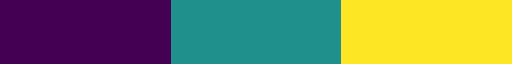

In [64]:
## Creating the legend for the visalization of each metric 

metric = []
## Support
supp = [194, 109, 107, 101,  73,  71,  63,  62,  60,  53,  53,  50,  44, 43,  43,  42,  35,  35,  33,  32,  32,  31,  27,  25,  25,  
        21, 21,  21,  20,  18,  18,  17,  17,  17,  17,  17,  16,  15,  15, 15,  15,  15,  13,  13,  13,  12,  12,  12,  12,  12,  12,  
        12, 12,  12,  12,  12,  12,  11,  11,  11,  11,  11,  11,  11,  11, 11,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10]
## Diversity by Distance covered Index
DDI = [0.738046, 3.904113, 0.648466, 0.757598, 1.352675, 3.316187, 0.723485, 0.227363, 1.757767, 0.646646, 0.351128, 2.309024, 0.084239, 4.597011, 
       2.946011, 0.148571, 1.648510, 1.850903, 0.960039, 2.939271, 2.173214, 2.794783, 2.609657, 0.078832, 2.083462, 0.129390, 2.693309, 1.608167, 
       0.132575, 2.149327, 2.386323, 1.957314, 0.542506, 1.804520, 1.471711, 5.910233, 0.268697, 0.612629, 0.061301, 0.412824, 2.287881, 3.770443, 
       0.718484, 4.789460, 2.620154, 0.210182, 0.205778, 4.425060, 0.648696, 0.753862, 3.675470, 2.083462, 7.691690, 1.727128, 0.240463, 3.922926, 
       0.879917, 2.108384, 4.465718, 0.689914, 1.543006, 0.684012, 5.574716, 3.129372, 5.961432, 2.812021, 0.364572, 1.008751, 0.640509, 2.375205, 
       8.413207, 2.693309, 1.727128, 2.526939, 1.727128, 1.367236, 0.477053, 0.989223]
## Nationality Diversity Index
NDI = [0.707071, 0.746032, 0.722222, 0.769231, 0.629630, 0.541667, 0.814815, 0.777778, 0.888889, 0.777778, 0.888889, 0.648148, 0.888889, 0.722222, 
       0.733333, 0.800000, 0.888889, 0.444444, 0.814815, 0.727273, 0.800000, 0.548148, 0.814815, 0.888889, 0.716049, 0.888889, 0.800000, 0.888889, 
       0.888889, 0.777778, 0.888889, 0.702742, 0.814815, 0.888889, 0.888889, 0.698413, 0.888889, 0.722222, 0.888889, 0.518519, 0.777778, 0.888889, 
       0.888889, 0.777778, 0.888889, 0.797980, 0.888889, 0.888889, 0.888889, 0.888889, 0.888889, 0.888889, 0.698413, 0.888889, 0.888889, 0.888889, 
       0.888889, 0.742424, 0.805556, 0.888889, 0.888889, 0.888889, 0.555556, 0.888889, 0.777778, 0.888889, 0.805556, 0.888889, 0.888889, 0.888889, 
       0.777778, 0.800000, 0.777778, 0.844444, 0.800000, 0.888889, 0.888889, 0.888889]
## Path Satisfaction Index
PSI = [3.834584, 3.494730, 3.794608, 3.612001, 3.695819, 3.945119, 3.859624, 4.009495, 3.681291, 3.652822, 3.820616, 4.033844, 3.709922, 3.969002, 
       4.046079, 3.849737, 3.932836, 3.761446, 3.649546, 3.920850, 4.033171, 3.793243, 3.977818, 3.711581, 3.849364, 3.732142, 3.851612, 4.165328, 
       3.895820, 3.948553, 3.749570, 3.880981, 3.809685, 3.987850, 4.063830, 3.906386, 3.701022, 3.824556, 3.845011, 3.854687, 3.878251, 3.751707, 
       3.740508, 3.691677, 3.967692, 3.902671, 3.659452, 4.226414, 3.783142, 3.986458, 3.655071, 3.840128, 3.914181, 3.858181, 3.973987, 3.310126, 
       4.358298, 3.876562, 3.856930, 3.738516, 3.723180, 3.687149, 3.645068, 3.631902, 3.917911, 3.894435, 3.920536, 3.955848, 3.779375, 3.957105, 
       3.767518, 3.968764, 3.910160, 4.005642, 4.026231, 3.898808, 4.006610, 4.164228]

##     Path Preference Index
PPI = [0.075325, 0.053435, 0.017199, 0.029851, 0.022222, 0.112903, 0.012225, 0.004854, 0.002421, 0.004854, 0.002421, 0.019704, 0.002421, 0.022222, 
       0.022222, 0.007299, 0.004854, 0.012225, 0.017199, 0.027295, 0.007299, 0.027295, 0.012225, 0.002421, 0.017199, 0.002421, 0.007299, 0.002421, 
       0.007299, 0.004854, 0.002421, 0.009050, 0.009756, 0.004854, 0.002421, 0.009050, 0.002421, 0.035000, 0.002421, 0.022222, 0.004854, 0.002421, 
       0.002421, 0.004854, 0.002421, 0.002247, 0.023256, 0.004587, 0.002421, 0.002421, 0.002421, 0.002421, 0.009756, 0.002421, 0.002247, 0.023256, 
       0.004587, 0.004505, 0.002915, 0.002421, 0.002421, 0.002421, 0.009756, 0.002421, 0.004505, 0.002915, 0.002915, 0.002421, 0.002421, 0.002421, 
       0.004854, 0.007299, 0.004854, 0.001553, 0.007299, 0.002421, 0.002915, 0.001553]

## Location-type Diversity Inde
LDI = [0.000000, 1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000, 1.000000, 1.000000, 0.000000, 1.000000, 1.000000, 0.000000, 1.000000, 
       1.000000, 0.000000, 1.000000, 1.000000, 0.000000, 1.000000, 1.000000, 1.000000, 1.000000, 0.000000, 1.000000, 0.000000, 1.000000, 1.000000, 
       0.000000, 1.000000, 1.000000, 0.918296, 0.000000, 1.000000, 1.000000, 1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 1.000000, 1.000000, 
       0.000000, 1.000000, 1.000000, 0.918296, 0.918296, 0.918296, 0.000000, 0.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 
       0.000000, 0.918296, 0.918296, 0.000000, 1.000000, 0.000000, 1.000000, 1.000000, 1.000000, 1.000000, 0.918296, 0.000000, 0.000000, 1.000000, 
       1.000000, 1.000000, 1.000000, 0.918296, 1.000000, 1.000000, 1.000000, 0.000000]

metric = LDI
print('min -> ', min(metric), 'max -> ', max(metric))
list_to_viz = [0,1,2,27,31,47,57,77]

hex_color_supp, cmap = create_colors(metric)
cmap


In [65]:
visu = visu_paths_metric(list_to_viz, g_lille, list_points, hex_color_supp, "LDI")
visu